Для воспроизводимости кода установим определенную версию tensorflow и keras

In [ ]:
!pip install -q tensorflow==2.11

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [ ]:
print("We're using TF", tf.__version__)
print("We are using Keras", keras.__version__)

We're using TF 2.11.0
We are using Keras 2.11.0


In [ ]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# GPU count and name
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e207ad2d-e2c8-0ec8-cc6d-4d0d4239a17a)


In [ ]:
# Use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi

Thu Mar 30 12:24:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    28W /  70W |    339MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# MNIST

In [ ]:
# Скачиваем данные
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# Смотрим данные
print(x_train.shape)
print(x_val.shape)
print (y_train[:10])
print (y_val[:10])

(60000, 28, 28)
(10000, 28, 28)
[5 0 4 1 9 2 1 3 1 4]
[7 2 1 0 4 1 4 9 5 9]


Пример кусочка картинки (пиксели со значениями от 0 до 255):


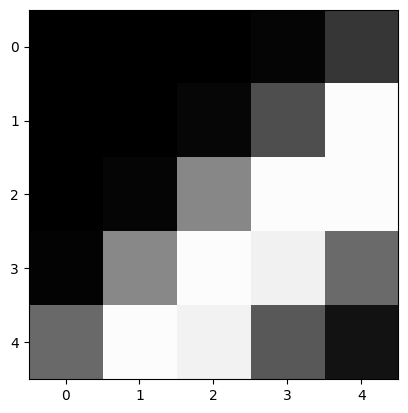

Пример картинки:


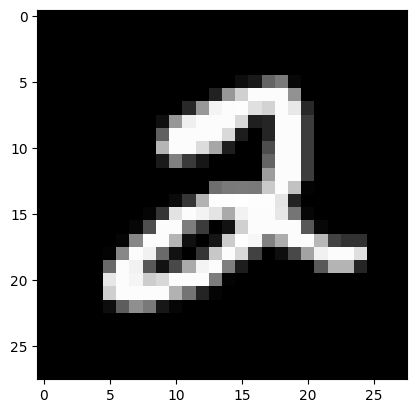

y_train [shape (60000,)] 10 примеров:
 [5 0 4 1 9 2 1 3 1 4]


In [ ]:
# Отобразим картинку
x_train_image = np.tile(x_train[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))
print("Пример кусочка картинки (пиксели со значениями от 0 до 255):")
plt.imshow(x_train_image[15:20, 5:10], cmap="Greys")
plt.show()
print("Пример картинки:")
plt.imshow(x_train_image, cmap="Greys")
plt.show()
print("y_train [shape %s] 10 примеров:\n" % (str(y_train.shape)), y_train[:10])

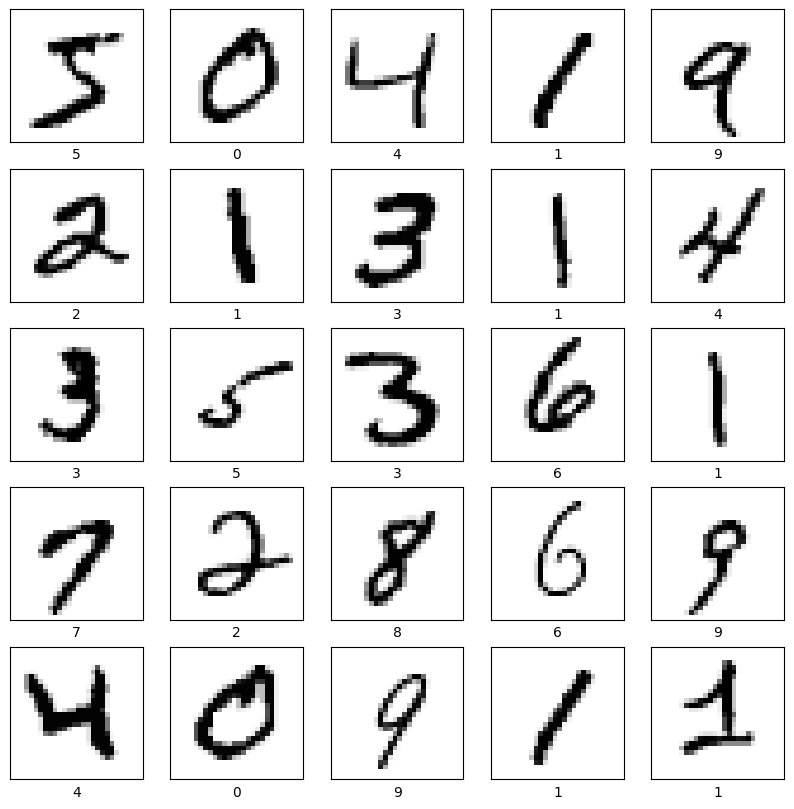

In [ ]:
# Посмотрим побольше примеров
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap="Greys")
    plt.xlabel(y_train[i])
plt.show()

# Data

In [ ]:
# Вытянем картинку в вектор размера 28*28=784 и будем использовать это как фичи

x_train_flat = x_train.reshape(-1, 28*28).astype(float)
print(x_train.shape, x_train_flat.shape)

x_val_flat = x_val.reshape(-1, 28*28).astype(float)
print(x_val.shape, x_val_flat.shape)

(60000, 28, 28) (60000, 784)
(10000, 28, 28) (10000, 784)


In [ ]:
# Центрируем и нормируем, для того чтобы сети было проще учиться
x_train_float = x_train_flat.astype(np.float) / 255 - 0.5
x_val_float = x_val_flat.astype(np.float) / 255 - 0.5

# Эти действия аналогичны нормализации через StandardScaler
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# x_train_flat = scaler.fit_transform(x_train_flat)
# x_val_flat = scaler.transform(x_val_flat)

<ipython-input-12-dd53c12ce9f9>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_train_float = x_train_flat.astype(np.float) / 255 - 0.5
<ipython-input-12-dd53c12ce9f9>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_val_float = x_val_flat.astype(np.float) / 255 - 0.5


In [ ]:
# One-hot encode для ответов
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:5], y_train[:5])

(60000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]] [5 0 4 1 9]


# Собираем модель

Построим простой Multi layer Perceptron (MLP) классификатор в Keras (по аналогии со знакомым нам уже MLPClassifier из sklearn)

<img src="https://cdn-images-1.medium.com/max/1600/1*Gh5PS4R_A5drl5ebd_gNrg@2x.png" width="500">


Сначала надо будет посчитать логиты (logit, линейное преобразование) $z_k$ для каждого класса: $$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0..9$$

А затем превратить логиты $z_k$ в вероятности $p_k$ при помощи функции softmax: $$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

Мы будем использовать cross-entropy для минимизации ошибки: $$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$

где $$ [x]=\begin{cases} 1, \quad \text{если $x$ истина} \\ 0, \quad \text{иначе} \end{cases} $$

Минимизация cross-entropy двигает $p_k$ в сторону 1 когда $y = k$, что как раз мы и хотим.


In [ ]:
clear_session()

In [ ]:
# Архитектура сети
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(x_train_float.shape[1],))) # первый скрытый слой
model.add(Dense(128, activation='relu',)) # второй скрытый слой
model.add(Dense(10, activation='softmax',)) # выходной слой

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer='adam',  # для ускорения
    metrics=['accuracy']  # выводим процент правильных ответов
)

In [ ]:
history = model.fit(
                    x_train_float,
                    y_train_oh,
                    batch_size=64,  # 64 объекта для подсчета градиента на каждом шаге
                    epochs=10,  # 10 проходов по датасету
                    validation_data=(x_val_float, y_val_oh)
                    )

Epoch 1/10
938/938 [==============================] - 14s 7ms/step - loss: 0.3010 - accuracy: 0.9086 - val_loss: 0.1552 - val_accuracy: 0.9536
Epoch 2/10
938/938 [==============================] - 4s 4ms/step - loss: 0.1371 - accuracy: 0.9581 - val_loss: 0.1120 - val_accuracy: 0.9666
Epoch 3/10
938/938 [==============================] - 3s 4ms/step - loss: 0.1030 - accuracy: 0.9681 - val_loss: 0.0973 - val_accuracy: 0.9693
Epoch 4/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0823 - accuracy: 0.9740 - val_loss: 0.0831 - val_accuracy: 0.9734
Epoch 5/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0720 - accuracy: 0.9775 - val_loss: 0.0827 - val_accuracy: 0.9744
Epoch 6/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0624 - accuracy: 0.9797 - val_loss: 0.0989 - val_accuracy: 0.9703
Epoch 7/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0542 - accuracy: 0.9825 - val_loss: 0.1172 - val_accuracy: 0.9671
Epoch

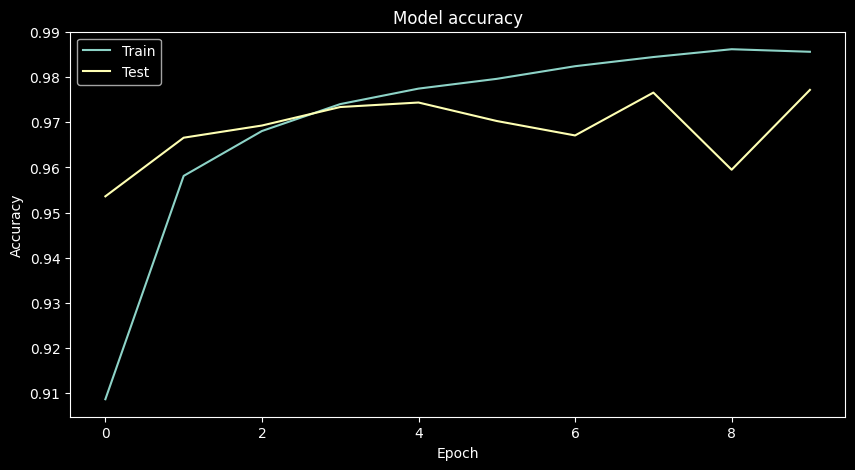

In [ ]:
# Plot training & validation accuracy values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

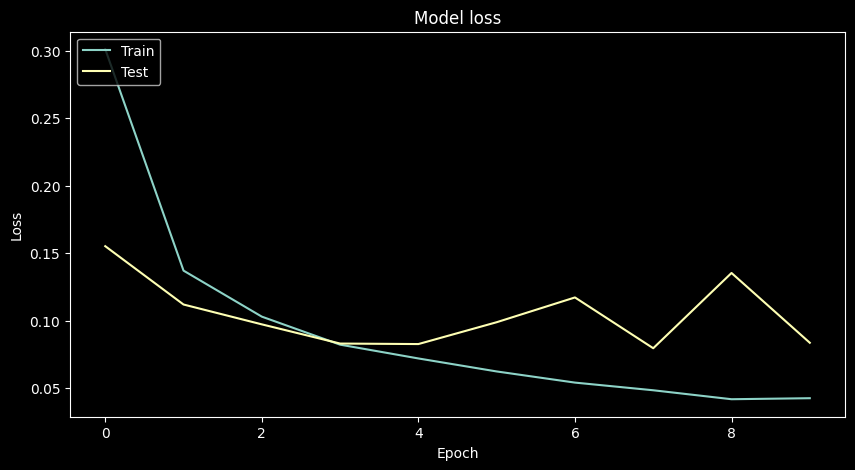

In [ ]:
# Plot training & validation loss values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model.predict(x_val_float)

313/313 [==============================] - 1s 2ms/step


array([[2.9573117e-08, 5.4670899e-08, 9.8544263e-08, ..., 9.9996090e-01,
        1.5840586e-08, 2.3895464e-05],
       [7.5512763e-11, 6.4162322e-07, 9.9999940e-01, ..., 1.4448276e-11,
        1.1538736e-08, 1.6009232e-15],
       [4.4060783e-08, 9.9993014e-01, 5.9222507e-06, ..., 2.4548956e-06,
        1.0296793e-05, 8.7971648e-06],
       ...,
       [1.2761573e-17, 1.8291319e-12, 5.6551883e-17, ..., 5.9815014e-11,
        1.2444330e-10, 8.6035801e-10],
       [1.3869166e-07, 9.7035677e-09, 8.7097094e-09, ..., 1.9314034e-06,
        1.2258216e-03, 2.5893099e-09],
       [1.3937232e-12, 3.6185597e-13, 1.2526195e-10, ..., 1.6967288e-13,
        3.6372896e-10, 5.7662680e-11]], dtype=float32)

In [ ]:
# предсказываем классы: определяем номер класса, для которого вероятность принадлежности максимальна
np.argmax(model.predict(x_val_float), axis = 1)

313/313 [==============================] - 0s 1ms/step


array([7, 2, 1, ..., 4, 5, 6])

In [ ]:
predicts = np.argmax(model.predict(x_val_float), axis = 1)
print('Test Accuracy: ', accuracy_score(y_val, predicts))

313/313 [==============================] - 1s 2ms/step
Test Accuracy:  0.9772
